In [1]:
#!pip install lightgbm
#!pip install fairlearn
#!pip install xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import EqualizedOdds
from sklearn.model_selection import train_test_split
import warnings

import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from scipy import stats

warnings.simplefilter("ignore")

rand_seed = 1234
np.random.seed(rand_seed)

In [2]:
df_cleaned = pd.read_csv("default_clean_v1.csv", index_col=0)

# Enocde target variable
df_cleaned['default'] = df_cleaned['default'].apply(lambda y: 1 if y == 'Yes' else 0)
df_cleaned = df_cleaned.drop(columns=["default payment next month"], axis=1)
df_cleaned

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,Female,Undergraduate,Married,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,Female,Undergraduate,Single,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,Female,Undergraduate,Single,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,Female,Undergraduate,Married,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,Male,Undergraduate,Married,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,Male,High School,Married,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,Male,High School,Single,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,Male,Undergraduate,Single,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,Male,High School,Married,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


## SEX

In [3]:
# Data imbalances
print(df_cleaned['SEX'].value_counts(normalize=True))
print(df_cleaned['default'].value_counts(normalize=True))

Female    0.603209
Male      0.396791
Name: SEX, dtype: float64
0    0.776892
1    0.223108
Name: default, dtype: float64


### Algorithm 1: Postprocessing: transforme the outputs of a trained classifer to satisfy some fairness criterion.
### Algorithm 2: Reductions: iteratively create a sequence of models that optimize some fairness constraint.

## Algorithm 1: Postprocessing mitigations: ThresholdOptimizer

In [4]:
df_cleaned

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,Female,Undergraduate,Married,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,Female,Undergraduate,Single,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,Female,Undergraduate,Single,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,Female,Undergraduate,Married,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,Male,Undergraduate,Married,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,Male,High School,Married,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,Male,High School,Single,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,Male,Undergraduate,Single,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,Male,High School,Married,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [5]:
categorical_features = ["SEX", "EDUCATION", "MARRIAGE"]

for col_name in categorical_features:
    df_cleaned[col_name] = df_cleaned[col_name].astype("category")

Y, A = df_cleaned.loc[:, "default"], df_cleaned.loc[:, "SEX"]
X = pd.get_dummies(df_cleaned.drop(columns=["default", "SEX"]))

In [6]:
def resample_training_data(X_train, Y_train, A_train):
    """Down-sample the majority class in the training dataset to produce a
    balanced dataset with a 50/50 split in the predictive labels.

    Parameters:
    X_train: The training split of the features
    Y_train: The training split of the target labels
    A_train: The training split of the sensitive features

    Returns:
    Tuple of X_train, Y_train, A_train where each dataset has been re-balanced.
    """
    negative_ids = Y_train[Y_train == 0].index
    positive_ids = Y_train[Y_train == 1].index
    balanced_ids = positive_ids.union(
        np.random.choice(a=negative_ids, size=len(positive_ids))
    )

    X_train = X_train.loc[balanced_ids, :]
    Y_train = Y_train.loc[balanced_ids]
    A_train = A_train.loc[balanced_ids]
    return X_train, Y_train, A_train

In [7]:
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, Y, A, test_size=0.35, stratify=Y
)

X_train, y_train, A_train = resample_training_data(X_train, y_train, A_train)

In [8]:
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  # For binary classification
    n_estimators=100,  # Number of boosting rounds
    max_depth=3,  # Maximum depth of trees
    learning_rate=0.1,  # Step size for each iteration
    random_state=42,
    n_jobs=1  # Number of threads for parallelism
)

# Create a scikit-learn Pipeline
estimator = Pipeline([
    ("preprocessing", StandardScaler()),  # Example preprocessing step (you can customize this)
    ("classifier", xgb_classifier)  # XGBoost classifier as the final step
])

# Fit the pipeline to your training data
estimator.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy

In [9]:
Y_pred_proba = estimator.predict_proba(X_test)[:, 1]
Y_pred = estimator.predict(X_test)

In [10]:
def compute_error_metric(metric_value, sample_size):
    """Compute standard error of a given metric based on the assumption of
    normal distribution.

    Parameters:
    metric_value: Value of the metric
    sample_size: Number of data points associated with the metric

    Returns:
    The standard error of the metric
    """
    metric_value = metric_value / sample_size
    return (
        1.96
        * np.sqrt(metric_value * (1.0 - metric_value))
        / np.sqrt(sample_size)
    )


def false_positive_error(y_true, y_pred):
    """Compute the standard error for the false positive rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fp, tn + fp)


def false_negative_error(y_true, y_pred):
    """Compute the standard error for the false negative rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fn, fn + tp)


def balanced_accuracy_error(y_true, y_pred):
    """Compute the standard error for the balanced accuracy estimate."""
    fpr_error, fnr_error = false_positive_error(
        y_true, y_pred
    ), false_negative_error(y_true, y_pred)
    return np.sqrt(fnr_error**2 + fpr_error**2) / 2


fairness_metrics = {
    "count": count,
    "balanced_accuracy": balanced_accuracy_score,
    "balanced_acc_error": balanced_accuracy_error,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "false_positive_error": false_positive_error,
    "false_negative_rate": false_negative_rate,
    "false_negative_error": false_negative_error,
}

In [11]:
metrics_to_report = [
    "balanced_accuracy",
    "false_positive_rate",
    "false_negative_rate",
]

In [12]:
metricframe_unmitigated = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=Y_pred,
    sensitive_features=A_test,
)

metricframe_unmitigated.by_group[metrics_to_report]

metricframe_unmitigated.difference()[metrics_to_report]

metricframe_unmitigated.overall[metrics_to_report]

balanced_accuracy      0.709273
false_positive_rate    0.204994
false_negative_rate    0.376460
dtype: float64

In [13]:
def plot_group_metrics_with_error_bars(metricframe, metric, error_name):
    """Plot the disaggregated metric for each group with an associated
    error bar. Both metric and the error bar are provided as columns in the
    provided MetricFrame.

    Parameters
    ----------
    metricframe : MetricFrame
        The MetricFrame containing the metrics and their associated
        uncertainty quantification.
    metric : str
        The metric to plot
    error_name : str
        The associated standard error for each metric in metric

    Returns
    -------
    Matplotlib Plot of point estimates with error bars
    """
    grouped_metrics = metricframe.by_group
    point_estimates = grouped_metrics[metric]
    error_bars = grouped_metrics[error_name]
    lower_bounds = point_estimates - error_bars
    upper_bounds = point_estimates + error_bars

    x_axis_names = [
        str(name) for name in error_bars.index.to_flat_index().tolist()
    ]
    plt.vlines(
        x_axis_names,
        lower_bounds,
        upper_bounds,
        linestyles="dashed",
        alpha=0.45,
    )
    plt.scatter(x_axis_names, point_estimates, s=25)
    plt.xticks(rotation=0)
    y_start, y_end = np.round(min(lower_bounds), decimals=2), np.round(
        max(upper_bounds), decimals=2
    )
    plt.yticks(np.arange(y_start, y_end, 0.05))
    plt.ylabel(metric)

array([[<AxesSubplot: title={'center': 'balanced_accuracy'}, xlabel='SEX'>,
        <AxesSubplot: title={'center': 'false_positive_rate'}, xlabel='SEX'>,
        <AxesSubplot: title={'center': 'false_negative_rate'}, xlabel='SEX'>]],
      dtype=object)

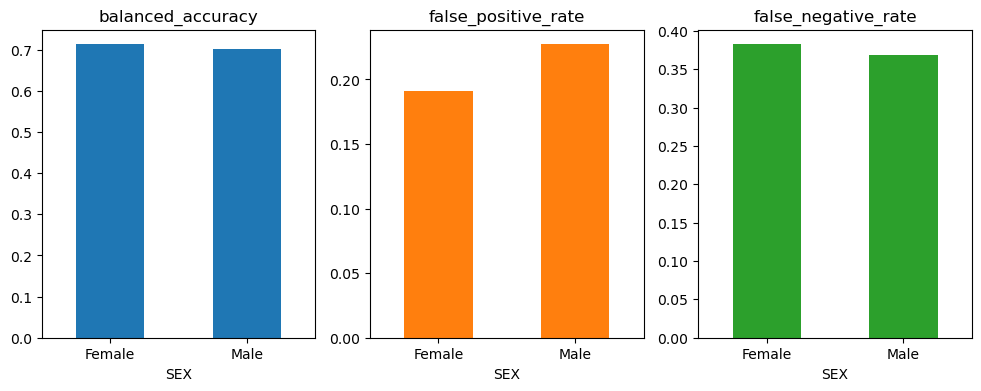

In [14]:
metricframe_unmitigated.by_group[metrics_to_report].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)

In [15]:
balanced_accuracy_unmitigated = balanced_accuracy_score(y_test, Y_pred)
equalized_odds_unmitigated = equalized_odds_difference(
    y_test, Y_pred, sensitive_features=A_test
)

# Start the Postprocessing mitigations

In [16]:
#postprocess_est = ThresholdOptimizer(
#    estimator=estimator,
#    constraints="equalized_odds",  # Optimize FPR and FNR simultaneously
#    objective="balanced_accuracy_score",
#    prefit=True,
#    predict_method="predict_proba",
#)

postprocess_est = ThresholdOptimizer(
    estimator=estimator,
    constraints="false_positive_rate_parity",  # Optimize FPR
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method="predict_proba"
)

In [17]:
postprocess_est.fit(X=X_train, y=y_train, sensitive_features=A_train)

postprocess_pred = postprocess_est.predict(X_test, sensitive_features=A_test)

postprocess_pred_proba = postprocess_est._pmf_predict(
    X_test, sensitive_features=A_test
)

In [18]:
def compare_metricframe_results(mframe_1, mframe_2, metrics, names):
    """Concatenate the results of two MetricFrames along a subset of metrics.

    Parameters
    ----------
    mframe_1: First MetricFrame for comparison
    mframe_2: Second MetricFrame for comparison
    metrics: The subset of metrics for comparison
    names: The names of the selected metrics

    Returns
    -------
    MetricFrame : MetricFrame
        The concatenation of the two MetricFrames, restricted to the metrics
        specified.

    """
    return pd.concat(
        [mframe_1.by_group[metrics], mframe_2.by_group[metrics]],
        keys=names,
        axis=1,
    )

In [19]:
bal_acc_postprocess = balanced_accuracy_score(y_test, postprocess_pred)
eq_odds_postprocess = equalized_odds_difference(
    y_test, postprocess_pred, sensitive_features=A_test
)

metricframe_postprocess = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=postprocess_pred,
    sensitive_features=A_test,
)

metricframe_postprocess.overall[metrics_to_report]

metricframe_postprocess.difference()[metrics_to_report]

balanced_accuracy      0.014814
false_positive_rate    0.002009
false_negative_rate    0.027619
dtype: float64

array([[<AxesSubplot: title={'center': 'balanced_accuracy'}, xlabel='SEX'>,
        <AxesSubplot: title={'center': 'false_positive_rate'}, xlabel='SEX'>,
        <AxesSubplot: title={'center': 'false_negative_rate'}, xlabel='SEX'>]],
      dtype=object)

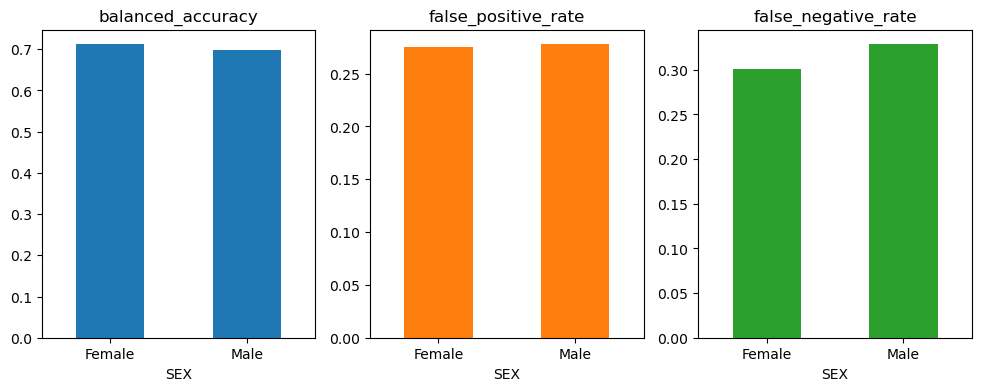

In [20]:
compare_metricframe_results(
    metricframe_unmitigated,
    metricframe_postprocess,
    metrics=metrics_to_report,
    names=["Unmitigated", "PostProcess"],
)

metricframe_postprocess.by_group[metrics_to_report].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)

In [21]:
eq_odds_postprocess

0.02761850414669409

## Algorithm 2: Reduction Approach

In [22]:
def get_expgrad_models_per_epsilon(
    estimator, epsilon, X_train, y_train, A_train
):
    """Instantiate and train an ExponentiatedGradient model on the
    balanced training dataset.

    Parameters
    ----------
    Estimator: Base estimator to contains a fit and predict function.
    Epsilon: Float representing maximum difference bound for the fairness Moment constraint

    Returns
    -------
    Predictors
        List of inner model predictors learned by the ExponentiatedGradient
        model during the training process.

    """
    exp_grad_est = ExponentiatedGradient(
        estimator=estimator,
        sample_weight_name='classifier__sample_weight',
        constraints=EqualizedOdds(difference_bound=epsilon),
    )
    # Is this an issue - Re-runs
    exp_grad_est.fit(X_train, y_train, sensitive_features=A_train)
    predictors = exp_grad_est.predictors_
    return predictors

In [23]:
epsilons = [0.01, 0.02]

In [24]:
all_models = {}
for eps in epsilons:
    all_models[eps] = get_expgrad_models_per_epsilon(
        estimator=estimator,
        epsilon=eps,
        X_train=X_train,
        y_train=y_train,
        A_train=A_train,
    )

In [25]:
for epsilon, models in all_models.items():
    print(
        f"For epsilon {epsilon}, ExponentiatedGradient learned {len(models)} inner models"
    )

For epsilon 0.01, ExponentiatedGradient learned 10 inner models
For epsilon 0.02, ExponentiatedGradient learned 6 inner models


In [26]:
def is_pareto_efficient(points):
    """Filter a NumPy Matrix to remove rows that are strictly dominated by
    another row in the matrix. Strictly dominated means the all the row values
    are greater than the values of another row.

    Parameters
    ----------
    Points: NumPy array (NxM) of model metrics.
        Assumption that smaller values for metrics are preferred.

    Returns
    -------
    Boolean Array
        Nx1 boolean mask representing the non-dominated indices.
    """
    n, m = points.shape
    is_efficient = np.ones(n, dtype=bool)
    for i, c in enumerate(points):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(
                points[is_efficient] < c, axis=1
            )
            is_efficient[i] = True
    return is_efficient

In [27]:
def filter_dominated_rows(points):
    """Remove rows from a DataFrame that are monotonically dominated by
    another row in the DataFrame.

    Parameters
    ----------
    Points: DataFrame where each row represents the summarized performance
            (balanced accuracy, fairness metric) of an inner model.

    Returns
    -------
    pareto mask: Boolean mask representing indices of input DataFrame that are not monotonically dominated.
    masked_DataFrame: DataFrame with dominated rows filtered out.

    """
    pareto_mask = is_pareto_efficient(points.to_numpy())
    return pareto_mask, points.loc[pareto_mask, :]

In [28]:
def aggregate_predictor_performances(
    predictors, metric, X_test, Y_test, A_test=None
):
    """Compute the specified metric for all classifiers in predictors.
    If no sensitive features are present, the metric is computed without
    disaggregation.

    Parameters
    ----------
    predictors: A set of classifiers to generate predictions from.
    metric: The metric (callable) to compute for each classifier in predictor
    X_test: The data features of the testing data set
    Y_test: The target labels of the teting data set
    A_test: The sensitive feature of the testing data set.

    Returns
    -------
    List of performance scores for each classifier in predictors, for the
    given metric.
    """
    all_predictions = [predictor.predict(X_test) for predictor in predictors]
    if A_test is not None:
        return [
            metric(Y_test, Y_sweep, sensitive_features=A_test)
            for Y_sweep in all_predictions
        ]
    else:
        return [metric(Y_test, Y_sweep) for Y_sweep in all_predictions]

In [29]:
def model_performance_sweep(models_dict, X_test, y_test, A_test):
    """Compute the equalized_odds_difference and balanced_error_rate for a
    given list of inner models learned by the ExponentiatedGradient algorithm.
    Return a DataFrame containing the epsilon level of the model, the index
    of the model, the equalized_odds_difference score and the balanced_error
    for the model.

    Parameters
    ----------
    models_dict: Dictionary mapping model ids to a model.
    X_test: The data features of the testing data set
    y_test: The target labels of the testing data set
    A_test: The sensitive feature of the testing data set.

    Returns
    -------
    DataFrame where each row represents a model (epsilon, index) and its
    performance metrics
    """
    performances = []
    for (eps, models) in models_dict.items():
        eq_odds_difference = aggregate_predictor_performances(
            models, equalized_odds_difference, X_test, y_test, A_test
        )
        bal_acc_score = aggregate_predictor_performances(
            models, balanced_accuracy_score, X_test, y_test
        )
        for (i, score) in enumerate(eq_odds_difference):
            performances.append((eps, i, score, (1 - bal_acc_score[i])))
    performances_df = pd.DataFrame.from_records(
        performances,
        columns=["epsilon", "index", "equalized_odds", "balanced_error"],
    )
    return performances_df

In [30]:
performance_df = model_performance_sweep(all_models, X_test, y_test, A_test)

In [31]:
performance_subset = performance_df.loc[
    :, ["equalized_odds", "balanced_error"]
]

In [32]:
mask, pareto_subset = filter_dominated_rows(performance_subset)

performance_df_masked = performance_df.loc[mask, :]

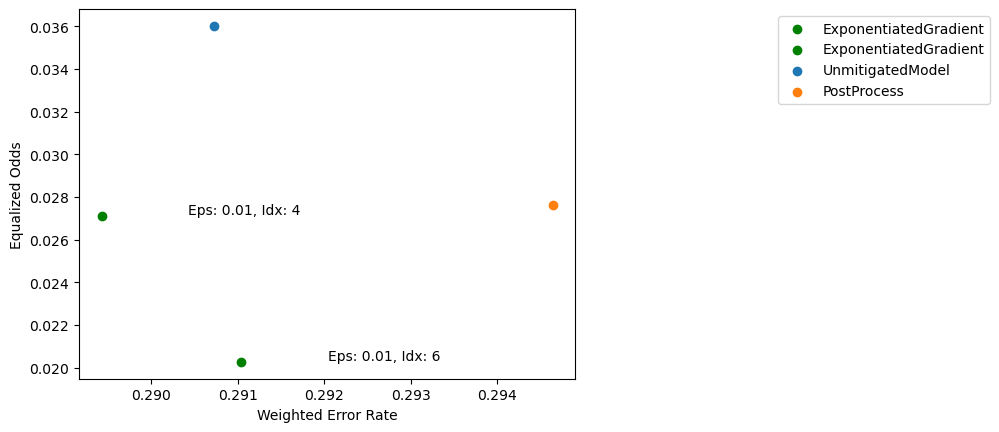

In [33]:
for index, row in performance_df_masked.iterrows():
    bal_error, eq_odds_diff = row["balanced_error"], row["equalized_odds"]
    epsilon_, index_ = row["epsilon"], row["index"]
    plt.scatter(
        bal_error, eq_odds_diff, color="green", label="ExponentiatedGradient"
    )
    plt.text(
        bal_error + 0.001,
        eq_odds_diff + 0.0001,
        f"Eps: {epsilon_}, Idx: {int(index_)}",
        fontsize=10,
    )
plt.scatter(
    1.0 - balanced_accuracy_unmitigated,
    equalized_odds_unmitigated,
    label="UnmitigatedModel",
)
plt.scatter(
    1.0 - bal_acc_postprocess, eq_odds_postprocess, label="PostProcess"
)
plt.xlabel("Weighted Error Rate")
plt.ylabel("Equalized Odds")
plt.legend(bbox_to_anchor=(1.85, 1))

In [34]:
def filter_models_by_unmitigiated_score(
    all_models,
    models_frames,
    unmitigated_score,
    performance_metric="balanced_error",
    fairness_metric="equalized_odds",
    threshold=0.01,
):
    """Filter out models whose performance score is above the desired
    threshold. Out of the remaining model, return the models with the best
    score on the fairness metric.

    Parameters
    ----------
    all_models: Dictionary (Epsilon, Index) mapping (epilson, index number) pairs to a Model object
    models_frames: A DataFrame representing each model's performance and fairness score.
    unmitigated_score: The performance score of the unmitigated model.
    performance_metric: The model performance metric to threshold on.
    fairness_metric: The fairness metric to optimize for
    threshold: The threshold padding added to the :code:`unmitigated_score`.

    """
    # Create threshold based on balanced_error of unmitigated model and filter
    models_filtered = models_frames.query(
        f"{performance_metric} <= {unmitigated_score + threshold}"
    )
    best_row = models_filtered.sort_values(by=[fairness_metric]).iloc[0]
    # Choose the model with smallest equalized_odds difference
    epsilon, index = best_row[["epsilon", "index"]]
    return {
        "model": all_models[epsilon][index],
        "epsilon": epsilon,
        "index": index,
    }

In [35]:
best_model = filter_models_by_unmitigiated_score(
    all_models,
    models_frames=performance_df,
    unmitigated_score=(1.0 - balanced_accuracy_unmitigated),
    threshold=0.015,
)

print(
    f"Epsilon for best model: {best_model.get('epsilon')}, Index number: {best_model.get('index')}"
)
inprocess_model = best_model.get("model")

Epsilon for best model: 0.01, Index number: 6.0


In [36]:
y_pred_inprocess = inprocess_model.predict(X_test)

bal_acc_inprocess = balanced_accuracy_score(y_test, y_pred_inprocess)
eq_odds_inprocess = equalized_odds_difference(
    y_test, y_pred_inprocess, sensitive_features=A_test
)

In [37]:
metricframe_inprocess = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=y_pred_inprocess,
    sensitive_features=A_test,
)


array([[<AxesSubplot: title={'center': 'balanced_accuracy'}, xlabel='SEX'>,
        <AxesSubplot: title={'center': 'false_positive_rate'}, xlabel='SEX'>,
        <AxesSubplot: title={'center': 'false_negative_rate'}, xlabel='SEX'>]],
      dtype=object)

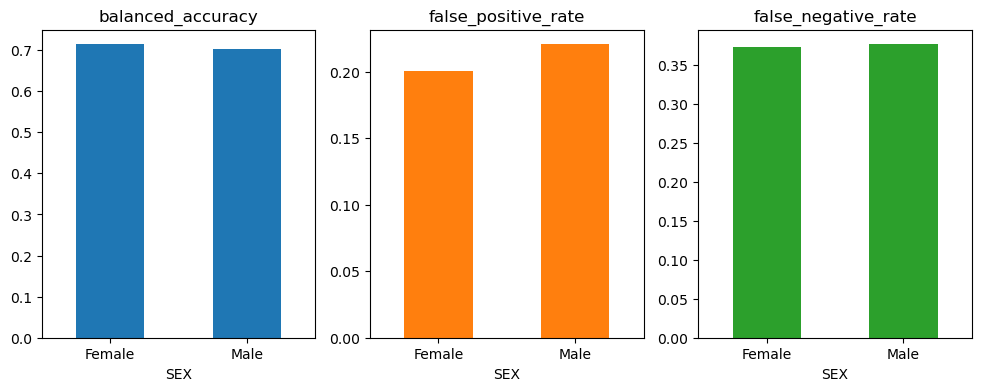

In [38]:
metricframe_inprocess.difference()[metrics_to_report]

metricframe_inprocess.overall[metrics_to_report]

metricframe_inprocess.by_group[metrics_to_report].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)

In [39]:
metric_error_pairs = [
    ("balanced_accuracy", "balanced_acc_error"),
    ("false_positive_rate", "false_positive_error"),
    ("false_negative_rate", "false_negative_error"),
]


def create_metricframe_w_errors(mframe, metrics_to_report, metric_error_pair):
    mframe_by_group = mframe.by_group.copy()
    for (metric_name, error_name) in metric_error_pair:
        mframe_by_group[metric_name] = mframe_by_group[metric_name].apply(
            lambda x: f"{x:.3f}"
        )
        mframe_by_group[error_name] = mframe_by_group[error_name].apply(
            lambda x: f"{x:.3f}"
        )
        mframe_by_group[metric_name] = mframe_by_group[metric_name].str.cat(
            mframe_by_group[error_name], sep="±"
        )
    return mframe_by_group[metrics_to_report]

In [40]:
metricframe_inprocess.difference()[metrics_to_report]

balanced_accuracy      0.011913
false_positive_rate    0.020268
false_negative_rate    0.003558
dtype: float64

In [41]:
eq_odds_inprocess

0.020268336279824634

## Comparison

In [42]:
# Algo1
metricframe_inprocess.overall[metrics_to_report]

create_metricframe_w_errors(
    metricframe_postprocess, metrics_to_report, metric_error_pairs
)

metricframe_postprocess.overall[metrics_to_report]


balanced_accuracy      0.705358
false_positive_rate    0.276432
false_negative_rate    0.312852
dtype: float64

In [43]:
# Algo2
create_metricframe_w_errors(
    metricframe_inprocess, metrics_to_report, metric_error_pairs
)

,balanced_accuracy,false_positive_rate,false_negative_rate
SEX,,,
Female,0.714±0.014,0.200±0.011,0.372±0.026
Male,0.702±0.017,0.221±0.015,0.376±0.030


In [44]:
import fairlearn.metrics
fairlearn.metrics.demographic_parity_ratio(y_true=y_test, y_pred=y_pred_inprocess,sensitive_features=A_test, method='between_groups', sample_weight=None)

0.9032306502246816

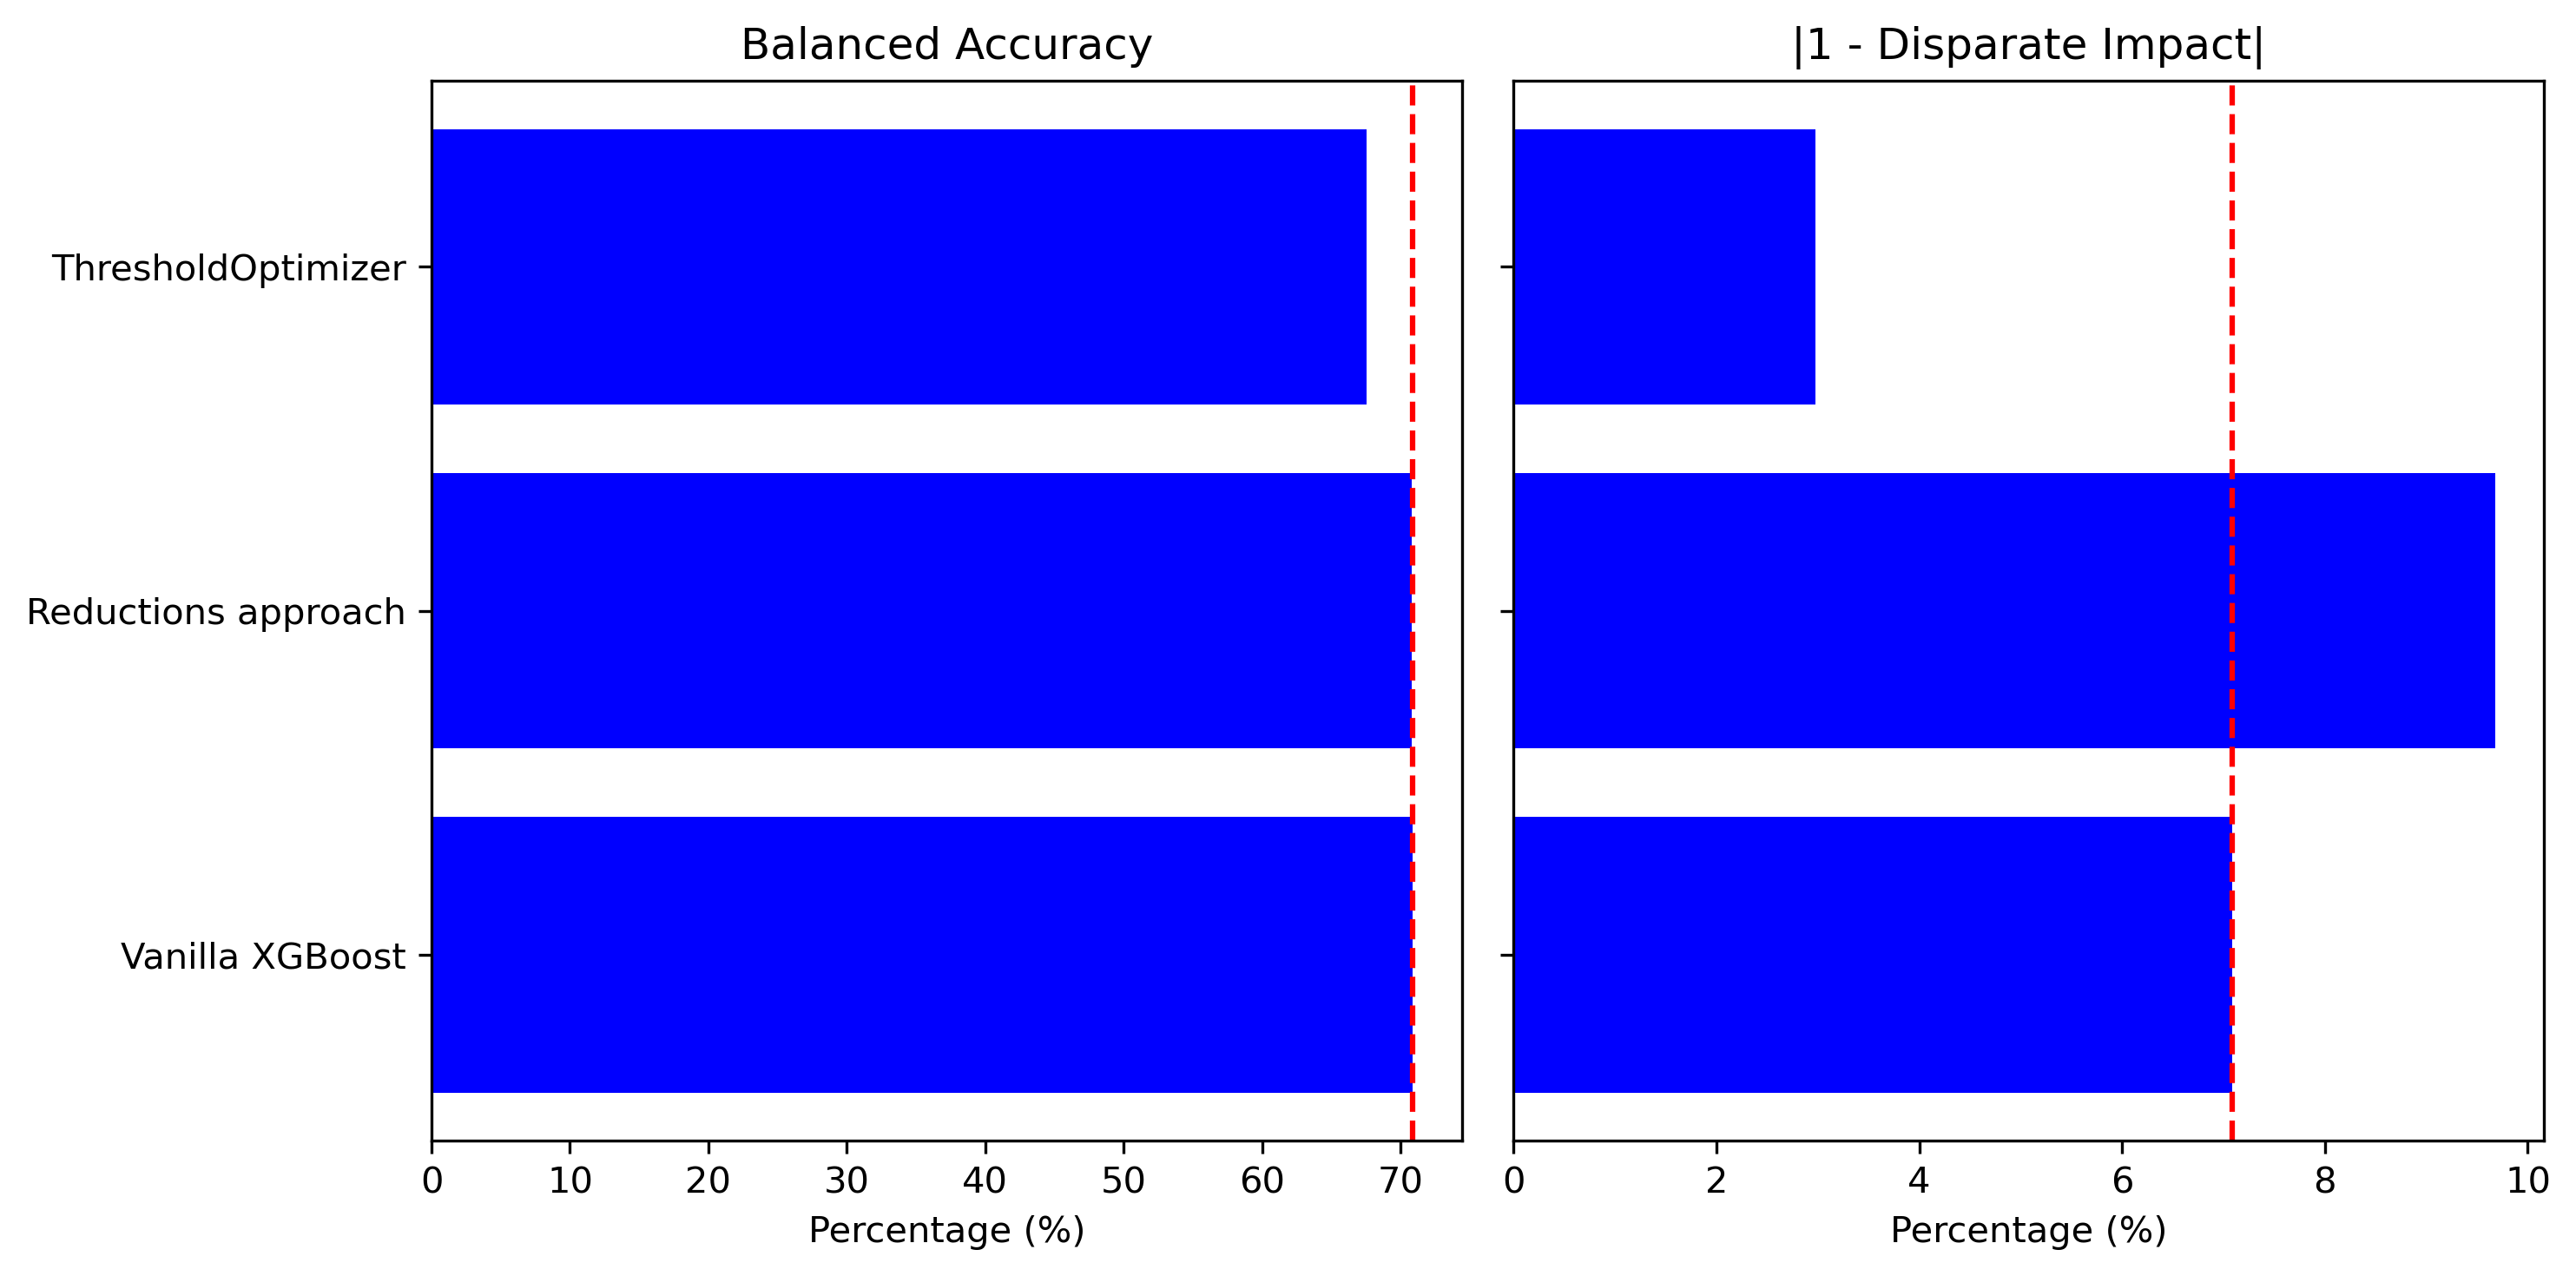

In [46]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# This is a set of fake value
aif_compare = {
    "name": ['Vanilla XGBoost', 'Reductions approach'],
    "balanced accuracy": [70.90393182610983, 70.8],  # Example values
    "disparate impact": [0.92911088770505, 0.9032306502246816]  # Example values
}

# New entry to be added
new_entry = {
    "name": "ThresholdOptimizer",
    "balanced accuracy": 67.5358,
    "disparate impact": 0.9702490092860946
}

# Add the new entry to the existing data
aif_compare["name"].append(new_entry["name"])
aif_compare["balanced accuracy"].append(new_entry["balanced accuracy"])
aif_compare["disparate impact"].append(new_entry["disparate impact"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Balanced Accuracy
axes[0].barh(np.arange(len(aif_compare["name"])), aif_compare["balanced accuracy"], color='blue')
axes[0].set_yticks(np.arange(len(aif_compare["name"])))
axes[0].set_yticklabels(aif_compare["name"])
axes[0].set_title("Balanced Accuracy")
axes[0].set_xlabel("Percentage (%)")
# Adding the red dashed line for Vanilla XGBoost accuracy
axes[0].axvline(x=70.90393182610983, color='red', linestyle='--', label='Vanilla XGBoost')

# Absolute Disparate Impact
disparate_impact_abs = np.abs((1 - np.array(aif_compare["disparate impact"]))*100)
axes[1].barh(np.arange(len(aif_compare["name"])), disparate_impact_abs, color='blue')
axes[1].set_yticks(np.arange(len(aif_compare["name"])))
axes[1].set_yticklabels(aif_compare["name"])
axes[1].set_title("|1 - Disparate Impact|")
axes[1].set_xlabel("Percentage (%)")
# Adding the red dashed line for Vanilla XGBoost disparate impact
axes[1].axvline(x=(1-0.92911088770505)*100, color='red', linestyle='--', label='Vanilla XGBoost')

plt.tight_layout()
plt.show()